In [1]:
import torch
import torchvision
from torch import nn, optim, autograd
from torch.nn import functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.autograd import Variable
import numpy as np
#import input_data
from sklearn.utils import shuffle as skshuffle
from math import *
from backpack import backpack, extend
from backpack.extensions import KFAC, DiagHessian, DiagGGNMC
from sklearn.metrics import roc_auc_score
import scipy
from tqdm import tqdm, trange
import pytest
from utils.LB_utils import * 
import time

import matplotlib.pyplot as plt
import matplotlib

np.random.seed(123)
torch.manual_seed(123)

from tueplots import bundles
plt.rcParams.update(bundles.icml2022())
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = 'Times new Roman'
matplotlib.rcParams['text.usetex'] = True

print(plt.rcParams['figure.figsize'])
figwidth = plt.rcParams['figure.figsize'][0]
figheight = plt.rcParams['figure.figsize'][1]
print(figheight)
print(figwidth)

[3.25, 2.0086104634371584]
2.0086104634371584
3.25


In [2]:
def get_alpha_from_Normal_old(mu, Sigma):
    alpha = []
    K = len(Sigma[0])
    sum_exp = np.sum(np.exp(-1*np.array(mu)))
    for k in range(K):
        alpha.append(1/Sigma[k][k]*(1 - 2/K + np.exp(mu[k])/K**2 * sum_exp))
        
    return(alpha)

def get_alpha_from_Normal(mu, Sigma):
    K = len(mu)
    sum_exp = np.sum(np.exp(-1*np.array(mu)))
    Sigma_d = np.diag(Sigma)
    alpha = 1/Sigma_d * (1- 2/K + np.exp(mu)/K**2 * sum_exp)    
    return(alpha)

def get_alpha_from_Normal_batch(mu, Sigma):
    mu, Sigma = torch.from_numpy(mu), torch.from_numpy(Sigma)
    batch_size, K = mu.size(0), mu.size(-1)
    Sigma_d = torch.diagonal(Sigma, dim1=1, dim2=2)
    sum_exp = torch.sum(torch.exp(-1*torch.Tensor(mu)), dim=1).view(-1,1)
    alpha = 1/Sigma_d * (1 - 2/K + torch.exp(mu)/K**2 * sum_exp)
    
    assert(alpha.size() == mu.size())
    
    return(alpha)

561


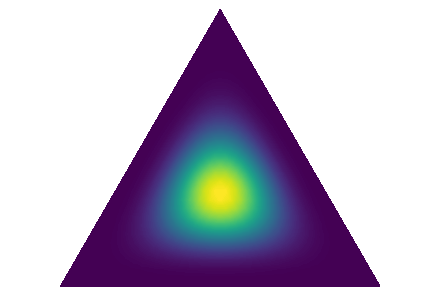

In [3]:
# just copy pasted from this link: http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import math
from functools import reduce
from math import gamma
from operator import mul
from scipy.special import loggamma, gammaln, xlogy

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)


"""
plt.figure(figsize=(8, 4))
for (i, mesh) in enumerate((triangle, trimesh)):
    plt.subplot(1, 2, i+ 1)
    plt.triplot(mesh)
    plt.axis('off')
    plt.axis('equal')
"""

midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]
def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

def logit_transform(x):
    
    out = np.log(x/(1-x))
    return(out)

def beta_function(alpha):
    return(np.exp(np.sum([loggamma(a_i) for a_i in alpha]) - loggamma(np.sum(alpha))))    

class Dirichlet(object):
    def __init__(self, alpha):
        self._alpha = np.array(alpha)
        self._coef = np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))    
        
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        #x = softmax_transform(x)
        return(np.exp(- self._coef+ np.sum((xlogy(self._alpha-1, x.T)).T, 0)))
    
class Normal3D(object):
    
    def __init__(self, mu, Sigma):
        self.mu = np.array(mu)
        self.Sigma = np.linalg.inv(np.array(Sigma))
        self.const = 1 / (np.sqrt((2*np.pi)**3 * np.linalg.det(Sigma)))
        
    def pdf(self, x):
        """Calculate 3D Gaussian"""
        y = self.const * np.exp(-0.5 * (x - self.mu).T @ self.Sigma @ (x - self.mu))
        return(y)
    
class logitNormal3D(object):
    
    def __init__(self, mu, Sigma):
        self.mu = np.array(mu)
        self.Sigma = np.array(Sigma)
        self.Sigma_inv = np.linalg.inv(np.array(Sigma))
        self.const = 1/ (np.sqrt(np.linalg.det(2 * np.pi * self.Sigma)))
        
    def pdf(self, x):
        part_one = self.const /np.prod(x*(1-x))
        logit = logit_transform(x)
        part_two = np.exp(-0.5*(logit - self.mu).T @ self.Sigma_inv @ (logit - self.mu))
        y = part_one * part_two
        return(y)
    
class softmaxNormal3D(object):
    
    def __init__(self, mu, Sigma, c):
        self.mu = np.array(mu)
        self.c = c * np.ones(len(mu))
        self.Sigma = np.array(Sigma)
        self.Sigma_inv = np.linalg.inv(np.array(Sigma))
        self.const = 1/ (np.sqrt(np.linalg.det(2 * np.pi * self.Sigma)))
        
    def pdf(self, x):
        part_one = self.const/ np.prod(1/x)
        sm_inv = np.log(x) + self.c
        part_two = np.exp(-0.5*(sm_inv - self.mu).T @ self.Sigma_inv @ (sm_inv - self.mu))
        y = part_one * part_two
        return(y)

def draw_pdf_contours(dist, nlevels=200, subdiv=5, **kwargs):

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]
    xys = [xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)]
    #print(len(pvals))
    #print(xys)
    print(len(xys))

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    
draw_pdf_contours(Dirichlet([5, 5, 5]))

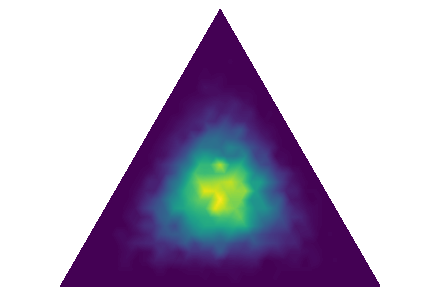

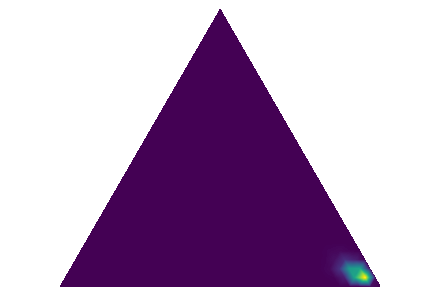

In [4]:
from scipy.stats import dirichlet, multivariate_normal

def softmax_transform(a):
    x = np.exp(a)/np.sum(np.exp(a))
    return(x)

def argmin_norm(sample, positions):
    return(np.argmin(np.sum(np.square(sample - positions), axis=1)))

def sample_dirichlet_contours(alpha, nlevels=200, subdiv=5, num_samples=10000, **kwargs):

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    dirichlet_samples = dirichlet.rvs(alpha, size=num_samples)
    counts = np.zeros(len(xys))
    for x in dirichlet_samples:
        counts[argmin_norm(x, xys)] += 1
    
    pvals = counts/num_samples

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.show()
    
def sample_Normal_contours(mu, sigma, nlevels=200, subdiv=5, num_samples=10000, **kwargs):

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    gaussian_samples = multivariate_normal.rvs(mean=mu, cov=sigma, size=num_samples)
    softmax_gaussian_samples = np.array([softmax_transform(x) for x in gaussian_samples])
    counts = np.zeros(len(xys))
    for x in softmax_gaussian_samples:
        counts[argmin_norm(x, xys)] += 1
    
    pvals = counts/num_samples

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.show()
    
    #return(xys, pvals)
    
sample_dirichlet_contours(np.array([5, 5, 5]))
sample_Normal_contours(np.array([-1, 2, -1]), 0.1*np.eye(3))

# check out the KL divergence for one example

In [5]:
from scipy.special import loggamma, xlogy, gammaln


def logit_transform(x):
    return(np.log(x/(1-x)))

def dirichlet_pdf(x, alpha):
    alpha = np.array(alpha)
    lnB = np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))    
    return(np.exp(- lnB + np.sum((xlogy(alpha-1, x.T)).T, 0)))
    
def logitNormal3D_pdf(x, mu, Sigma):
    
    mu = np.array(mu)
    Sigma = np.array(Sigma)
    Sigma_inv = np.linalg.inv(np.array(Sigma))
    const = 1/(np.sqrt(np.linalg.det(2 * np.pi * Sigma)))

    part_one = const / np.prod(x*(1-x))
    logit = logit_transform(x)
    part_two = np.exp(-0.5*(logit - mu).T @ Sigma_inv @ (logit - mu))
    y = part_one * part_two
    return(y)

def softmax_normal_pdf(x, mu, Sigma, c):
    mu = np.array(mu)
    Sigma = np.array(Sigma)
    Sigma_inv = np.linalg.inv(np.array(Sigma))
    const = 1/(np.sqrt(np.linalg.det(2 * np.pi * Sigma)))
    
    part_one = const/ np.prod(1/x)
    sm_inv = np.log(x) + c
    part_two = np.exp(-0.5*(sm_inv - mu).T @ Sigma_inv @ (sm_inv - mu))
    y = part_one * part_two
    return(y)

In [6]:
### test cases:

mu1 = np.array([0,0,0])
Sigma1 = 0.1*np.eye(3)
t0 = time.process_time()
alpha1 = get_alpha_from_Normal(mu1, Sigma1)
t1 = time.process_time()
Dirichlet_1_time = t1 - t0
print("alpha1: ", alpha1)

mu2 = np.array([2,-1,-1])
Sigma2 = 1*np.eye(3)
t0 = time.process_time()
alpha2 = get_alpha_from_Normal(mu2, Sigma2)
t1 = time.process_time()
Dirichlet_2_time = t1 - t0
print("alpha2: ", alpha2)

mu3 = np.array([1,1,-2])
Sigma3 = np.array([[1,     0, 0.5],
                   [0,     2, 0.3],
                   [0.5, 0.3, 0.5]])
t0 = time.process_time()
alpha3 = get_alpha_from_Normal(mu3, Sigma3)
t1 = time.process_time()
Dirichlet_3_time = t1 - t0
print("alpha3: ", alpha3)

mu4 = np.array([3,-2,-1])
Sigma4 = 1*np.eye(3)
t0 = time.process_time()
alpha4 = get_alpha_from_Normal(mu4, Sigma4)
t1 = time.process_time()
Dirichlet_4_time = t1 - t0
print("alpha4: ", alpha4)

x1 = np.array([1/3]*3)
#x2 = np.array([0.999, 0.0005, 0.0005])
x2 = np.array([0.8, 0.1, 0.1])

print("Dirichlet x1, a1: ", dirichlet_pdf(x1, alpha1))
print("Dirichlet x1, a2: ", dirichlet_pdf(x1, alpha2))
print("Dirichlet x2, a1: ", dirichlet_pdf(x2, alpha1))
print("Dirichlet x2, a2: ", dirichlet_pdf(x2, alpha2))

print("logitNormal x1, m1, S1: ", logitNormal3D_pdf(x1, mu1, Sigma1))
print("logitNormal x1, m2, S2: ", logitNormal3D_pdf(x1, mu2, Sigma2))
print("logitNormal x2, m1, S1: ", logitNormal3D_pdf(x2, mu1, Sigma1))
print("logitNormal x2, m2, S2: ", logitNormal3D_pdf(x2, mu2, Sigma2))

print("softmaxNormal x1, m1, S1: ", softmax_normal_pdf(x1, mu1, Sigma1, c=1))
print("softmaxNormal x1, m2, S2: ", softmax_normal_pdf(x1, mu2, Sigma2, c=1))
print("softmaxNormal x2, m1, S1: ", softmax_normal_pdf(x2, mu1, Sigma1, c=1))
print("softmaxNormal x2, m2, S2: ", softmax_normal_pdf(x2, mu2, Sigma2, c=1))

alpha1:  [6.66666667 6.66666667 6.66666667]
alpha2:  [4.90789709 0.56108745 0.56108745]
alpha3:  [2.78728188 1.39364094 0.91101647]
alpha4:  [23.00125657  0.4860686   0.74851083]
Dirichlet x1, a1:  15.998067072830981
Dirichlet x1, a2:  0.08609075690213953
Dirichlet x2, a1:  0.002707938331158549
Dirichlet x2, a2:  7.581916853300082
logitNormal x1, m1, S1:  0.13567391195402193
logitNormal x1, m2, S2:  0.14011904024999516
logitNormal x2, m1, S1:  1.1223088716939438e-22
logitNormal x2, m2, S2:  9.679333903157055
softmaxNormal x1, m1, S1:  0.06427139733022627
softmaxNormal x1, m2, S2:  0.00011538467163493116
softmaxNormal x2, m1, S1:  3.3614598920171183e-11
softmaxNormal x2, m2, S2:  0.00021937517873910986


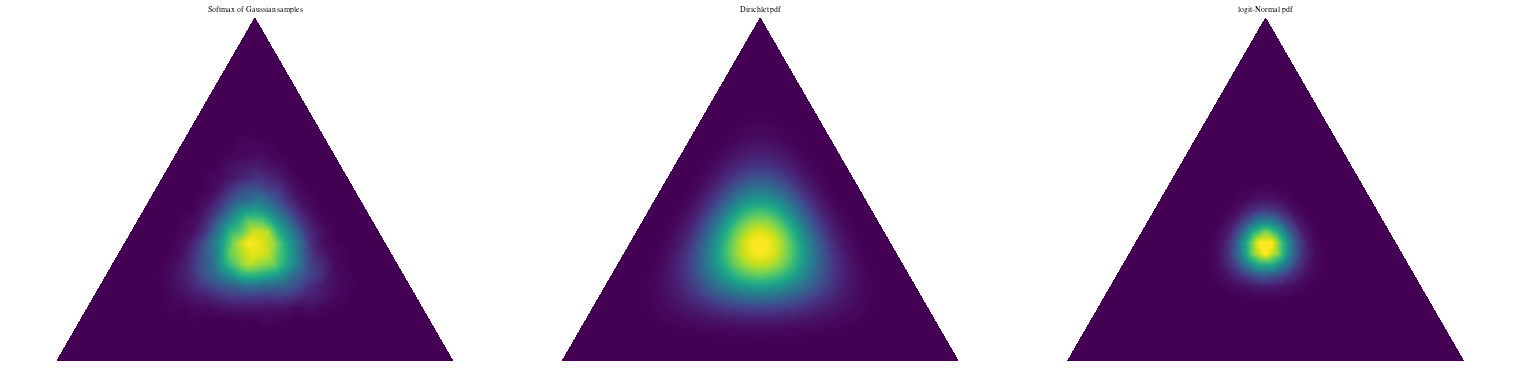

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(21, 5))

mu = mu1
Sigma = Sigma1
alpha = alpha1
num_samples = 25000
subdiv=5
nlevels = 200
#VALUES
#softmax(samples)
gaussian_samples = multivariate_normal.rvs(mean=mu, cov=Sigma, size=num_samples)
softmax_gaussian_samples = np.array([softmax_transform(x) for x in gaussian_samples])
#dirichlet_samples
dirichlet_samples = dirichlet.rvs(alpha, size=num_samples)

#PLOTS
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=subdiv)
xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
#plot softmax(Gaussian) samples
counts_n = np.zeros(len(xys))
for x in softmax_gaussian_samples:
    counts_n[argmin_norm(x, xys)] += 1

pvals_n = counts_n/num_samples

cs = axs[0].tricontourf(trimesh, pvals_n, nlevels)
for c in cs.collections:
    c.set_rasterized(True)
axs[0].axis('equal')
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 0.75**0.5)
axs[0].axis('off')
axs[0].set_title("Softmax of Gaussian samples")

#plot Dirichlet McKay pdf
dist_McKay = Dirichlet(alpha)
pvals_McKay = [dist_McKay.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

cs = axs[1].tricontourf(trimesh, pvals_McKay, nlevels)
for c in cs.collections:
    c.set_rasterized(True)
axs[1].axis('equal')
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 0.75**0.5)
axs[1].axis('off')
axs[1].set_title("Dirichlet pdf")

#plot logitnormal

dist_logitNormal = logitNormal3D(mu, Sigma)
pvals_logitNormal = [dist_logitNormal.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

cs = axs[2].tricontourf(trimesh, pvals_logitNormal, nlevels)
for c in cs.collections:
    c.set_rasterized(True)
axs[2].axis('equal')
axs[2].set_xlim(0, 1)
axs[2].set_ylim(0, 0.75**0.5)
axs[2].axis('off')
axs[2].set_title("logit-Normal pdf")

plt.savefig('logitNormal_comparison_v1.pdf')
plt.show()

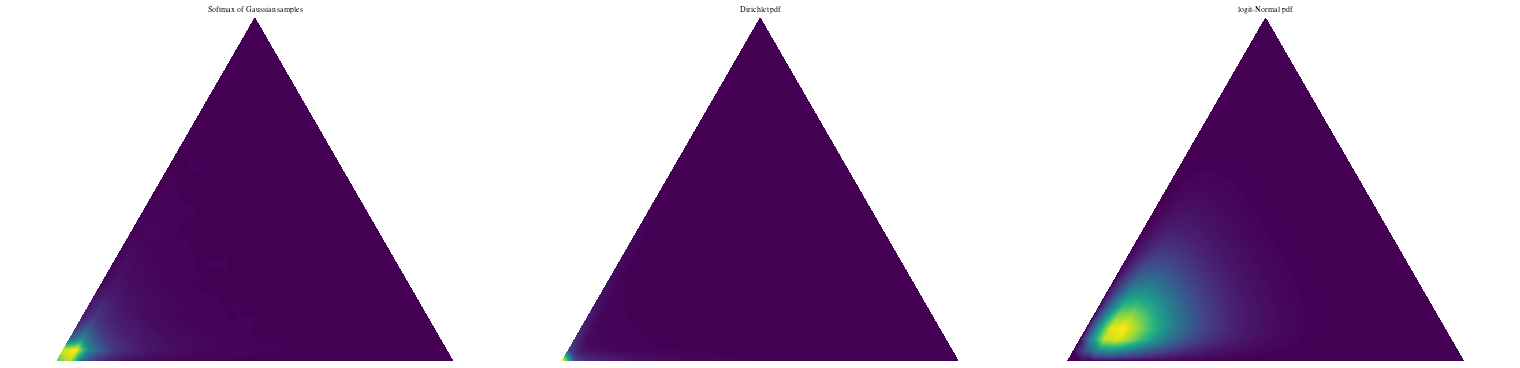

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(21, 5))

mu = mu2
Sigma = Sigma2
alpha = alpha2
num_samples = 25000
subdiv=5
nlevels = 200
#VALUES
#softmax(samples)
gaussian_samples = multivariate_normal.rvs(mean=mu, cov=Sigma, size=num_samples)
softmax_gaussian_samples = np.array([softmax_transform(x) for x in gaussian_samples])
#dirichlet_samples
dirichlet_samples = dirichlet.rvs(alpha, size=num_samples)

#PLOTS
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=subdiv)
xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
#plot softmax(Gaussian) samples
counts_n = np.zeros(len(xys))
for x in softmax_gaussian_samples:
    counts_n[argmin_norm(x, xys)] += 1

pvals_n = counts_n/num_samples

cs = axs[0].tricontourf(trimesh, pvals_n, nlevels)
for c in cs.collections:
    c.set_rasterized(True)
axs[0].axis('equal')
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 0.75**0.5)
axs[0].axis('off')
axs[0].set_title("Softmax of Gaussian samples")

#plot Dirichlet McKay pdf
dist_McKay = Dirichlet(alpha)
pvals_McKay = [dist_McKay.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

cs = axs[1].tricontourf(trimesh, pvals_McKay, nlevels)
for c in cs.collections:
    c.set_rasterized(True)
axs[1].axis('equal')
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 0.75**0.5)
axs[1].axis('off')
axs[1].set_title("Dirichlet pdf")

#plot logitnormal

dist_logitNormal = logitNormal3D(mu, Sigma)
pvals_logitNormal = [dist_logitNormal.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

cs = axs[2].tricontourf(trimesh, pvals_logitNormal, nlevels)
for c in cs.collections:
    c.set_rasterized(True)
axs[2].axis('equal')
axs[2].set_xlim(0, 1)
axs[2].set_ylim(0, 0.75**0.5)
axs[2].axis('off')
axs[2].set_title("logit-Normal pdf")

plt.savefig('logitNormal_comparison_v2.pdf')
plt.show()

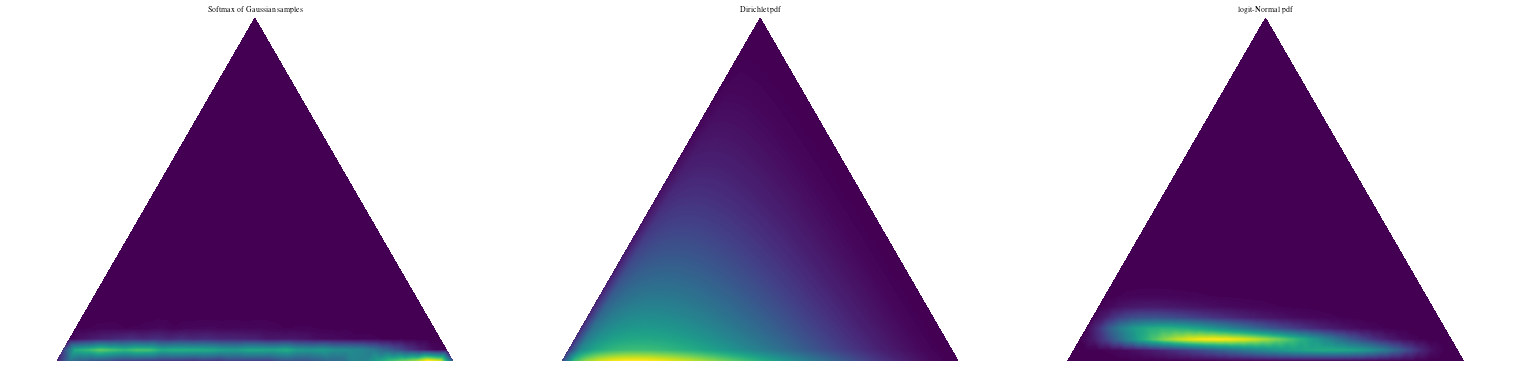

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(21, 5))

mu = mu3
Sigma = Sigma3
alpha = alpha3
num_samples = 25000
subdiv=5
nlevels = 200
#VALUES
#softmax(samples)
gaussian_samples = multivariate_normal.rvs(mean=mu, cov=Sigma, size=num_samples)
softmax_gaussian_samples = np.array([softmax_transform(x) for x in gaussian_samples])
#dirichlet_samples
dirichlet_samples = dirichlet.rvs(alpha, size=num_samples)

#PLOTS
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=subdiv)
xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
#plot softmax(Gaussian) samples
counts_n = np.zeros(len(xys))
for x in softmax_gaussian_samples:
    counts_n[argmin_norm(x, xys)] += 1

pvals_n = counts_n/num_samples

cs = axs[0].tricontourf(trimesh, pvals_n, nlevels)
for c in cs.collections:
    c.set_rasterized(True)
axs[0].axis('equal')
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 0.75**0.5)
axs[0].axis('off')
axs[0].set_title("Softmax of Gaussian samples")

#plot Dirichlet McKay pdf
dist_McKay = Dirichlet(alpha)
pvals_McKay = [dist_McKay.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

cs = axs[1].tricontourf(trimesh, pvals_McKay, nlevels)
for c in cs.collections:
    c.set_rasterized(True)
axs[1].axis('equal')
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 0.75**0.5)
axs[1].axis('off')
axs[1].set_title("Dirichlet pdf")

#plot logitnormal

dist_logitNormal = logitNormal3D(mu, Sigma)
pvals_logitNormal = [dist_logitNormal.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

cs = axs[2].tricontourf(trimesh, pvals_logitNormal, nlevels)
for c in cs.collections:
    c.set_rasterized(True)
axs[2].axis('equal')
axs[2].set_xlim(0, 1)
axs[2].set_ylim(0, 0.75**0.5)
axs[2].axis('off')
axs[2].set_title("logit-Normal pdf")

plt.savefig('logitNormal_comparison_v3.pdf')
plt.show()

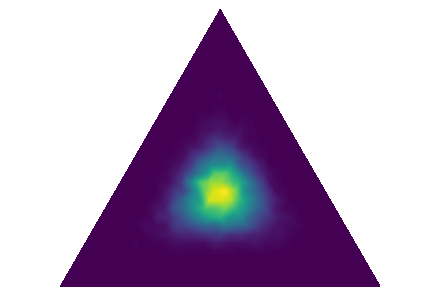

561


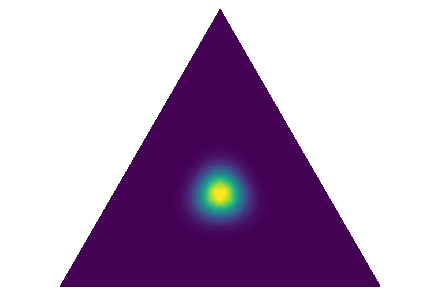

In [10]:
#sample_dirichlet_contours(alpha1)
sample_Normal_contours(mu1, Sigma1)
draw_pdf_contours(logitNormal3D(mu1, Sigma1))

561


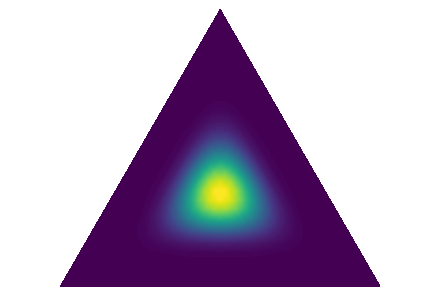

In [11]:
draw_pdf_contours(softmaxNormal3D(mu=mu1, Sigma=Sigma1, c=1.5))

561


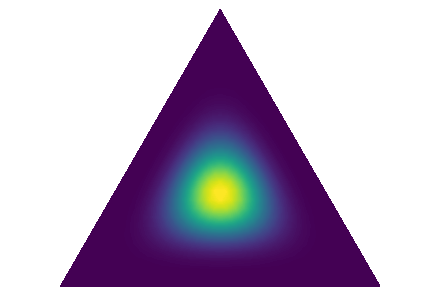

In [12]:
draw_pdf_contours(Dirichlet(alpha1))

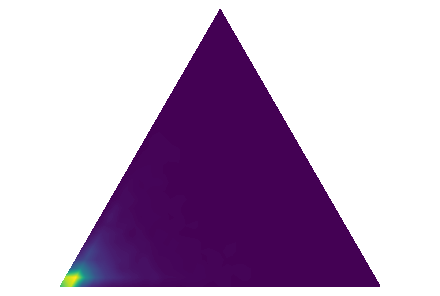

561


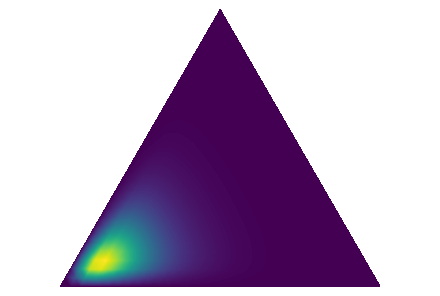

In [13]:
sample_Normal_contours(mu2, Sigma2)
draw_pdf_contours(logitNormal3D(mu2, Sigma2))

561


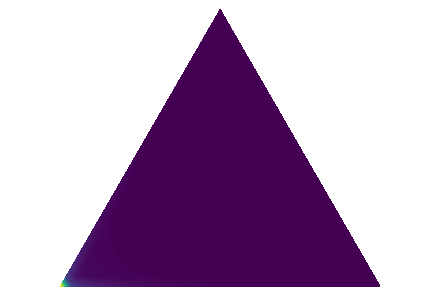

In [14]:
draw_pdf_contours(Dirichlet(alpha2))

561


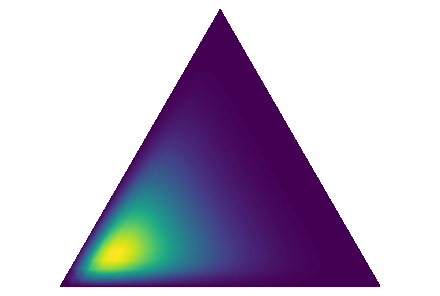

In [15]:
draw_pdf_contours(softmaxNormal3D(mu=mu2, Sigma=Sigma2, c=2))

In [16]:
def sample_Normal_softmax(mu, sigma, nlevels=200, subdiv=5, num_samples=10000, **kwargs):

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    t0 = time.process_time()
    gaussian_samples = multivariate_normal.rvs(mean=mu, cov=sigma, size=num_samples)
    softmax_gaussian_samples = np.array([softmax_transform(x) for x in gaussian_samples])
    t1 = time.process_time()
    time_diff = t1 - t0
    counts = np.zeros(len(xys))
    for x in softmax_gaussian_samples:
        counts[argmin_norm(x, xys)] += 1
    
    pvals = counts/num_samples
    
    return(xys, pvals, time_diff)

In [17]:
#check out Samples vs Dir
def Dir_vs_True_Gaussian_KL_divergence(alpha, x_space, true_Gaussian):
    
    KL_div = 0
    dir_pvals = []
    for i, x in enumerate(x_space):
        
        dir_pdf = dirichlet_pdf(x, alpha)
        dir_pvals.append(dir_pdf)
        
    #normalize both dists
    dir_pvals = np.array(dir_pvals) + 1e-20
    dir_pvals /= dir_pvals.sum()
    for i in range(len(true_Gaussian)):
        true_gaussian_pdf = true_Gaussian[i]
        dir_pdf = dir_pvals[i]
        KL_div += true_gaussian_pdf * np.log(true_gaussian_pdf/dir_pdf)
        
    return(KL_div)

def Gaussian_samples_vs_True_Gaussian_KL_divergence(mu, Sigma, x_space, true_Gaussian, num_samples):
    
    KL_div = 0

    _, pvals, time_diff = sample_Normal_softmax(mu, Sigma, num_samples = num_samples)
    sm_gaussian_pvals = []
    for i, x in enumerate(x_space):
        
        sm_gaussian_pdf = 1e-20 if pvals[i] == 0 else pvals[i]
        sm_gaussian_pvals.append(sm_gaussian_pdf)
        
    #normalize both dists
    sm_gaussian_pvals = np.array(sm_gaussian_pvals)
    sm_gaussian_pvals /= sm_gaussian_pvals.sum()
    for i in range(len(sm_gaussian_pvals)):
        sm_gaussian_pdf = sm_gaussian_pvals[i]
        true_gaussian_pdf = true_Gaussian[i]
        KL_div += true_gaussian_pdf * np.log(true_gaussian_pdf/sm_gaussian_pdf)
        
    return(KL_div, time_diff)
   

In [18]:
x_space, true_pvals1, _ = sample_Normal_softmax(mu1, Sigma1, num_samples = 100000)
x_space, true_pvals2, _ = sample_Normal_softmax(mu2, Sigma2, num_samples = 100000)
x_space, true_pvals3, _ = sample_Normal_softmax(mu3, Sigma3, num_samples = 100000)
true_pvals1 = np.array(true_pvals1) + 1e-20
true_pvals1 /= true_pvals1.sum()
true_pvals2 = np.array(true_pvals2) + 1e-20
true_pvals2 /= true_pvals2.sum()
true_pvals3 = np.array(true_pvals3) + 1e-20
true_pvals3 /= true_pvals3.sum()

In [19]:
def Gaussian_vs_Dirichlet(seeds):
    
    KL1_Gaussian_list = []
    KL2_Gaussian_list = []
    KL3_Gaussian_list = []
    Gaussian1_timing_list = []
    Gaussian2_timing_list = []
    Gaussian3_timing_list = []
    
    for s in seeds:
        
        np.random.seed(s)
        torch.manual_seed(s)
        
        KL1_Gaussian = []
        KL2_Gaussian = []
        KL3_Gaussian = []
        KL1_Dirichlet = Dir_vs_True_Gaussian_KL_divergence(alpha1, x_space, true_pvals1)
        KL2_Dirichlet = Dir_vs_True_Gaussian_KL_divergence(alpha2, x_space, true_pvals2)
        KL3_Dirichlet = Dir_vs_True_Gaussian_KL_divergence(alpha3, x_space, true_pvals3)
        Gaussian_1_timing = []
        Gaussian_2_timing = []
        Gaussian_3_timing = []

        print("KL1_Dirichlet: ", KL1_Dirichlet)
        print("KL2_Dirichlet: ", KL2_Dirichlet)
        print("KL3_Dirichlet: ", KL3_Dirichlet)

        sample_sizes = [1, 5,
                        10, 25, 50, 75,
                        100, 250, 500, 750,
                        1000, 2500, 5000, 7500,
                        10000, 25000, 50000, 75000,
                        100000]

        for s in sample_sizes:
            Gaussian_samples_KL_div1, time1 = Gaussian_samples_vs_True_Gaussian_KL_divergence(mu1, Sigma1, x_space, true_pvals1, num_samples=s)
            Gaussian_samples_KL_div2, time2 = Gaussian_samples_vs_True_Gaussian_KL_divergence(mu2, Sigma2, x_space, true_pvals2, num_samples=s)
            Gaussian_samples_KL_div3, time3 = Gaussian_samples_vs_True_Gaussian_KL_divergence(mu3, Sigma3, x_space, true_pvals3, num_samples=s)
            KL1_Gaussian.append(Gaussian_samples_KL_div1)
            KL2_Gaussian.append(Gaussian_samples_KL_div2)
            KL3_Gaussian.append(Gaussian_samples_KL_div3)
            Gaussian_1_timing.append(time1)
            Gaussian_2_timing.append(time2)
            Gaussian_3_timing.append(time3)
            print("Gaussian_samples_KL_div1: ", Gaussian_samples_KL_div1)
            print("Gaussian_samples_KL_div2: ", Gaussian_samples_KL_div2)
            print("Gaussian_samples_KL_div3: ", Gaussian_samples_KL_div3)
            print("time1: ", time1)
            print("time2: ", time2)
            print("time3: ", time3)
            
        KL1_Gaussian_list.append(np.array(KL1_Gaussian))
        KL2_Gaussian_list.append(np.array(KL2_Gaussian))
        KL3_Gaussian_list.append(np.array(KL3_Gaussian))
        Gaussian1_timing_list.append(np.array(Gaussian_1_timing))
        Gaussian2_timing_list.append(np.array(Gaussian_2_timing))
        Gaussian3_timing_list.append(np.array(Gaussian_3_timing))
        
    print(KL1_Gaussian_list)
    KL1_Gaussian_mean = np.mean(KL1_Gaussian_list, axis=0)
    KL2_Gaussian_mean = np.mean(KL2_Gaussian_list, axis=0)
    KL3_Gaussian_mean = np.mean(KL3_Gaussian_list, axis=0)
    Gaussian1_timing_mean = np.mean(Gaussian1_timing_list, axis=0)
    Gaussian2_timing_mean = np.mean(Gaussian2_timing_list, axis=0)
    Gaussian3_timing_mean = np.mean(Gaussian3_timing_list, axis=0)
    KL1_Gaussian_std = np.std(KL1_Gaussian_list, axis=0)
    KL2_Gaussian_std = np.std(KL2_Gaussian_list, axis=0)
    KL3_Gaussian_std = np.std(KL3_Gaussian_list, axis=0)
    Gaussian1_timing_std = np.std(Gaussian1_timing_list, axis=0)
    Gaussian2_timing_std = np.std(Gaussian2_timing_list, axis=0)
    Gaussian3_timing_std = np.std(Gaussian3_timing_list, axis=0)
    
    return(KL1_Gaussian_mean, 
           KL2_Gaussian_mean,
           KL3_Gaussian_mean,
           KL1_Gaussian_std,
           KL2_Gaussian_std,
           KL3_Gaussian_std,
           KL1_Dirichlet,
           KL2_Dirichlet,
           KL3_Dirichlet,
           Gaussian1_timing_mean,
           Gaussian2_timing_mean,
           Gaussian3_timing_mean,
           Gaussian1_timing_std,
           Gaussian2_timing_std,
           Gaussian3_timing_std)

    

In [20]:
seeds = [123, 234, 345, 456, 567]
KL1_Gaussian_mean, KL2_Gaussian_mean, KL3_Gaussian_mean, KL1_Gaussian_std, KL2_Gaussian_std, KL3_Gaussian_std, \
KL1_Dirichlet, KL2_Dirichlet,  KL3_Dirichlet, Gaussian1_timing_mean, Gaussian2_timing_mean,\
Gaussian3_timing_mean, Gaussian1_timing_std, Gaussian2_timing_std, Gaussian3_timing_std = Gaussian_vs_Dirichlet(seeds)

KL1_Dirichlet:  0.08817099700242213
KL2_Dirichlet:  0.7075459257046993
KL3_Dirichlet:  1.7655057604949025
Gaussian_samples_KL_div1:  41.37227028232162
Gaussian_samples_KL_div2:  43.0508627605988
Gaussian_samples_KL_div3:  42.93349488395003
time1:  0.00026383099999804926
time2:  0.00021527699999879246
time3:  0.0001843810000003998
Gaussian_samples_KL_div1:  38.94362447906433
Gaussian_samples_KL_div2:  37.67081816574378
Gaussian_samples_KL_div3:  38.68437050404743
time1:  0.00032185199999901215
time2:  0.00027712099999988027
time3:  0.00022981599999738478
Gaussian_samples_KL_div1:  36.53962947879275
Gaussian_samples_KL_div2:  32.05606146260672
Gaussian_samples_KL_div3:  36.033002491131484
time1:  0.00021373899999943546
time2:  0.00019365500000034785
time3:  0.00020493499999929554
Gaussian_samples_KL_div1:  28.02311749088691
Gaussian_samples_KL_div2:  21.566603518298848
Gaussian_samples_KL_div3:  26.184336530157342
time1:  0.00028044600000143305
time2:  0.00027853599999971834
time3:  0.00

Gaussian_samples_KL_div1:  0.013150703206418453
Gaussian_samples_KL_div2:  0.022667884180506227
Gaussian_samples_KL_div3:  0.009683519000104794
time1:  0.5895018759999999
time2:  0.6382926200000014
time3:  0.6572848469999997
Gaussian_samples_KL_div1:  0.010539190034223364
Gaussian_samples_KL_div2:  0.016825734223673852
Gaussian_samples_KL_div3:  0.004284839024513732
time1:  0.7782507729999963
time2:  0.7790884489999996
time3:  0.8328821749999946
KL1_Dirichlet:  0.08817099700242213
KL2_Dirichlet:  0.7075459257046993
KL3_Dirichlet:  1.7655057604949025
Gaussian_samples_KL_div1:  41.37227028232162
Gaussian_samples_KL_div2:  43.0508627605988
Gaussian_samples_KL_div3:  42.93349488395003
time1:  0.00030984599999328566
time2:  0.0003090759999935244
time3:  0.0003031040000109897
Gaussian_samples_KL_div1:  38.9702898374328
Gaussian_samples_KL_div2:  36.5859825027866
Gaussian_samples_KL_div3:  36.93290088187853
time1:  0.00027502300000037394
time2:  0.00025216099999170183
time3:  0.00032750799999

Gaussian_samples_KL_div1:  0.035533164968865605
Gaussian_samples_KL_div2:  0.09663596855558308
Gaussian_samples_KL_div3:  0.019666059213918983
time1:  0.22771238199999289
time2:  0.26102837300000203
time3:  0.22602940800000226
Gaussian_samples_KL_div1:  0.021347980484659614
Gaussian_samples_KL_div2:  0.042211753526617754
Gaussian_samples_KL_div3:  0.007536274939427632
time1:  0.4696855880000044
time2:  0.4472249140000031
time3:  0.4373845769999889
Gaussian_samples_KL_div1:  0.013589491323716101
Gaussian_samples_KL_div2:  0.025157194184984376
Gaussian_samples_KL_div3:  0.007154872699209303
time1:  0.6199795819999991
time2:  0.6743351849999897
time3:  0.601302234000002
Gaussian_samples_KL_div1:  0.00938493657803245
Gaussian_samples_KL_div2:  0.018862321359728557
Gaussian_samples_KL_div3:  0.006862983752319675
time1:  0.905538364999984
time2:  0.846609003999987
time3:  0.9030739899999958
KL1_Dirichlet:  0.08817099700242213
KL2_Dirichlet:  0.7075459257046993
KL3_Dirichlet:  1.7655057604949

In [21]:
# calculate the cutoff points
print(KL1_Gaussian_mean,  KL1_Dirichlet)
sample_sizes = [1, 5,  10, 25, 50, 75,
                100, 250, 500, 750,
                1000, 2500, 5000, 7500,
                10000, 25000, 50000, 75000,
                100000]
cutoff1 = sample_sizes[np.sum(KL1_Gaussian_mean>KL1_Dirichlet)]
cutoff2 = sample_sizes[np.sum(KL2_Gaussian_mean>KL2_Dirichlet)]
cutoff3 = sample_sizes[np.sum(KL3_Gaussian_mean>KL3_Dirichlet)]

[4.13722703e+01 3.89412255e+01 3.61002133e+01 3.03777697e+01
 2.27320648e+01 1.71614592e+01 1.38924157e+01 5.99287428e+00
 2.80812349e+00 1.83860200e+00 1.17705473e+00 4.35228119e-01
 2.55209761e-01 1.52354646e-01 9.54769807e-02 3.91865304e-02
 2.05855290e-02 1.46253994e-02 1.12571923e-02] 0.08817099700242213


/tmp/ipykernel_43739/3918648397.py:34: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


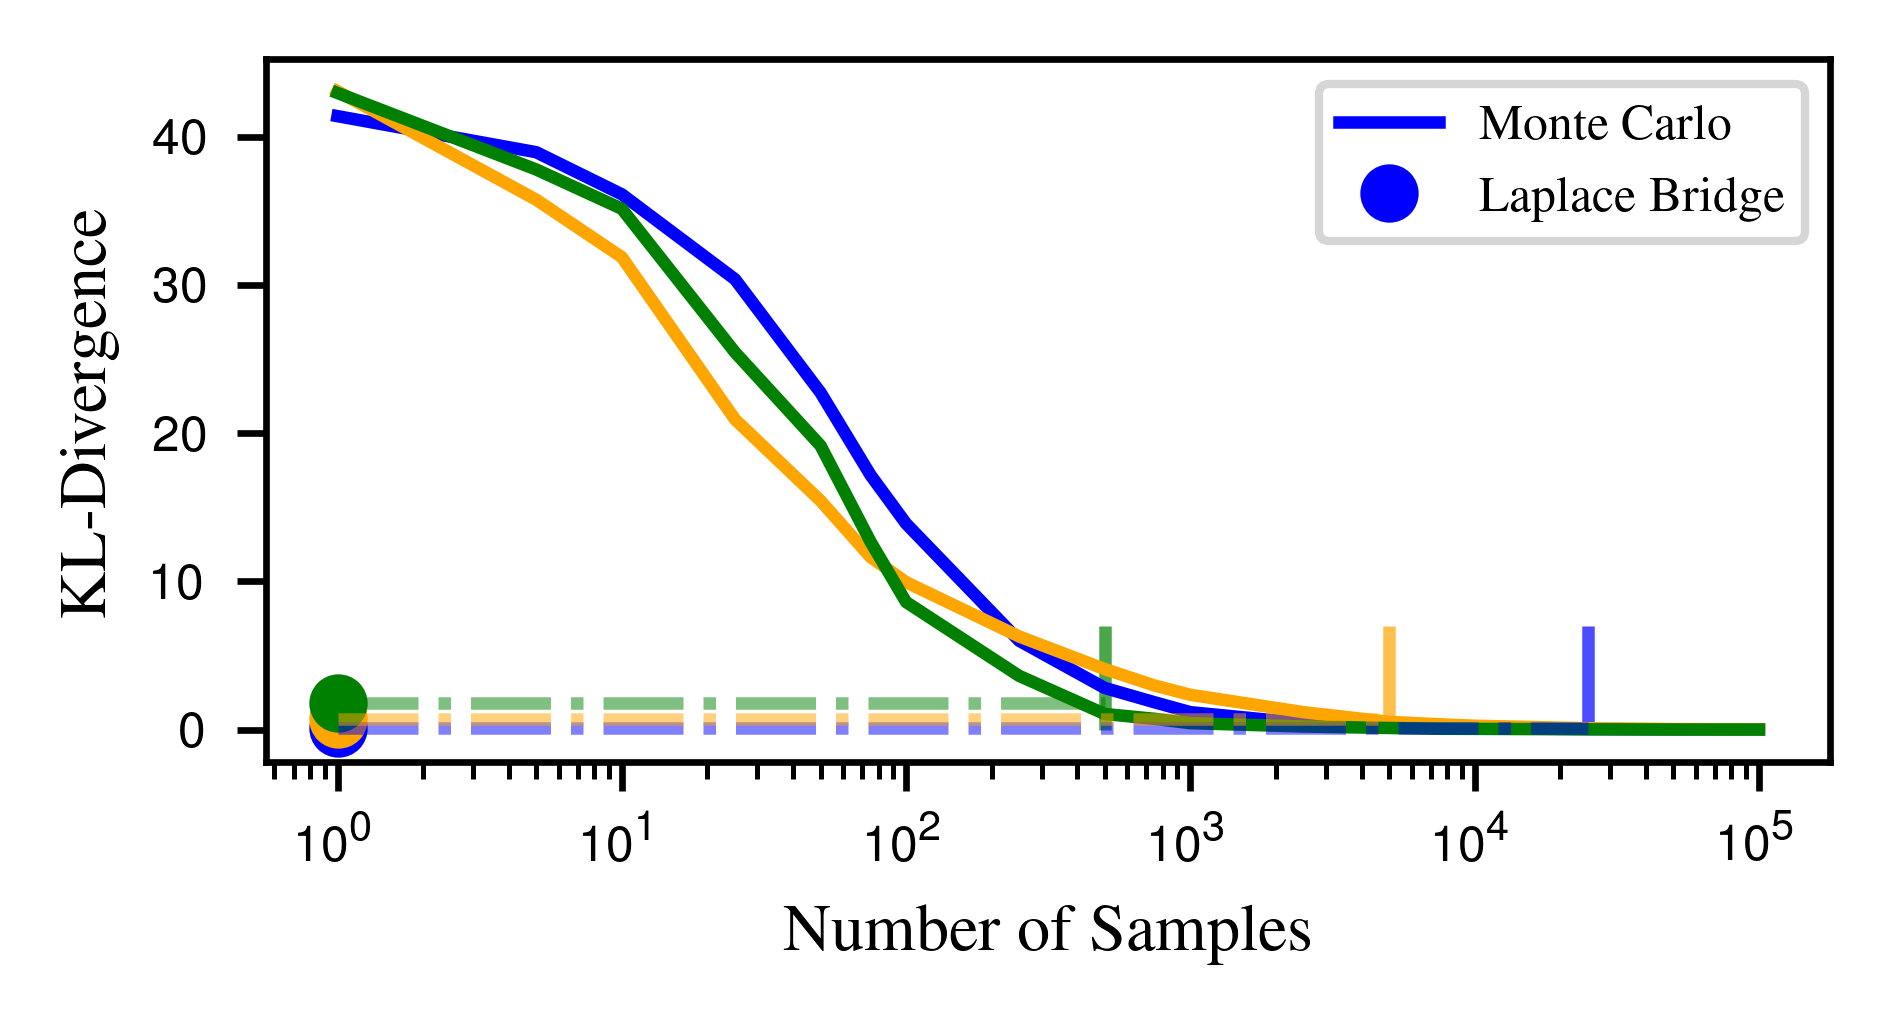

In [29]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
#### sample_sizes ####
fig = plt.figure(figsize=(figwidth, 0.9*figheight), dpi=600)

n = len(sample_sizes)
sample_line1 = [1, cutoff1]
sample_line2 = [1, cutoff2]
sample_line3 = [1, cutoff3]

#plt.errorbar(sample_sizes, KL1_Gaussian_mean, yerr=KL1_Gaussian_std, color="blue", label='Monte Carlo')
#plt.errorbar(sample_sizes, KL2_Gaussian_mean, yerr=KL2_Gaussian_std, color="orange")
#plt.errorbar(sample_sizes, KL3_Gaussian_mean, yerr=KL3_Gaussian_std, color="green")
plt.plot(sample_sizes, KL1_Gaussian_mean, color="blue", label='Monte Carlo')
plt.plot(sample_sizes, KL2_Gaussian_mean, color="orange")
plt.plot(sample_sizes, KL3_Gaussian_mean, color="green")
plt.plot(1, KL1_Dirichlet, 'o', color="blue", label = 'Laplace Bridge')
plt.plot(1, KL2_Dirichlet, 'o', color="orange")
plt.plot(1, KL3_Dirichlet, 'o', color="green")
plt.plot(sample_line1, [KL1_Dirichlet]*2, '-.', alpha=0.5, color="blue")
plt.plot(sample_line2, [KL2_Dirichlet]*2, '-.', alpha=0.5, color="orange")
plt.plot(sample_line3, [KL3_Dirichlet]*2, '-.', alpha=0.5, color="green")

# red purple brown
#cutoff points
plt.vlines(cutoff1, ymin=0, ymax=7, alpha=0.7, color="blue")
plt.vlines(cutoff2, ymin=0, ymax=7, alpha=0.7, color="orange")
plt.vlines(cutoff3, ymin=0, ymax=7, alpha=0.7, color="green")
plt.ylabel('KL-Divergence')
plt.xlabel('Number of Samples')
plt.xscale('log');
leg = plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('figures/KLDivSamples.pdf')

plt.show()

In [23]:
# calculate the cutoff points
cutoff1_time = Gaussian1_timing_mean[np.sum(KL1_Gaussian_mean>KL1_Dirichlet)]
cutoff2_time = Gaussian2_timing_mean[np.sum(KL2_Gaussian_mean>KL2_Dirichlet)]
cutoff3_time = Gaussian3_timing_mean[np.sum(KL3_Gaussian_mean>KL3_Dirichlet)]

/tmp/ipykernel_43739/3039041061.py:28: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


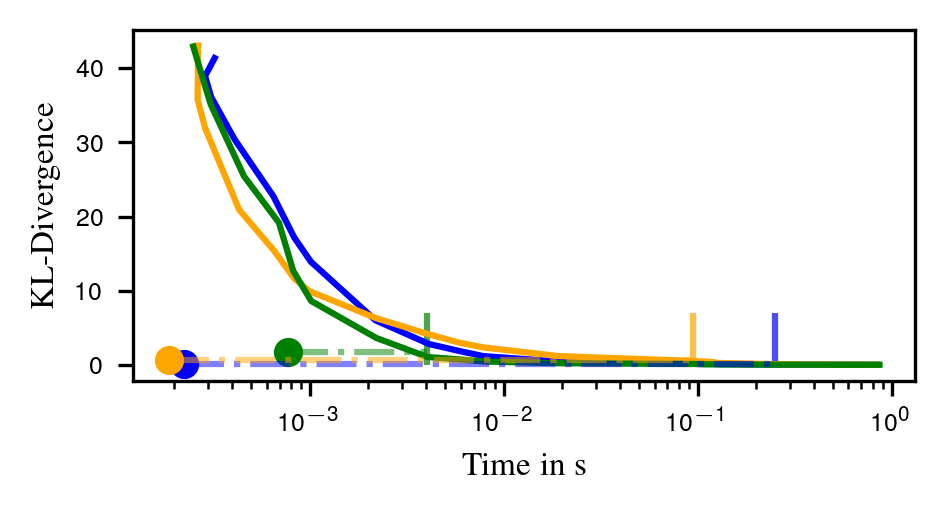

In [24]:
##### timing ####
fig = plt.figure(figsize=(figwidth, 0.9*figheight), dpi=300)

n = len(sample_sizes)
time_line1 = [Dirichlet_1_time, cutoff1_time]
time_line2 = [Dirichlet_2_time, cutoff2_time]
time_line3 = [Dirichlet_3_time, cutoff3_time]
#plt.errorbar(Gaussian1_timing_mean, KL1_Gaussian_mean, yerr=KL1_Gaussian_std, color="blue", label='Monte Carlo')
#plt.errorbar(Gaussian2_timing_mean, KL2_Gaussian_mean, yerr=KL2_Gaussian_std, color="orange")
#plt.errorbar(Gaussian3_timing_mean, KL3_Gaussian_mean, yerr=KL3_Gaussian_std, color="green")
plt.plot(Gaussian1_timing_mean, KL1_Gaussian_mean, color="blue", label='Monte Carlo')
plt.plot(Gaussian2_timing_mean, KL2_Gaussian_mean, color="orange")
plt.plot(Gaussian3_timing_mean, KL3_Gaussian_mean, color="green")
plt.plot(Dirichlet_1_time, KL1_Dirichlet, 'o', color="blue", label = 'Laplace Bridge')
plt.plot(Dirichlet_2_time, KL2_Dirichlet, 'o', color="orange")
plt.plot(Dirichlet_3_time, KL3_Dirichlet, 'o', color="green")
plt.plot(time_line1, [KL1_Dirichlet]*2, '-.', alpha=0.5, color="blue")
plt.plot(time_line2, [KL2_Dirichlet]*2, '-.', alpha=0.5, color="orange")
plt.plot(time_line3, [KL3_Dirichlet]*2, '-.', alpha=0.5, color="green")
#cutoff points
plt.vlines(cutoff1_time, ymin=0, ymax=7, alpha=0.7, color="blue")
plt.vlines(cutoff2_time, ymin=0, ymax=7, alpha=0.7, color="orange")
plt.vlines(cutoff3_time, ymin=0, ymax=7, alpha=0.7, color="green")
plt.ylabel('KL-Divergence')
plt.xlabel('Time in s')
plt.xscale('log');

plt.tight_layout()
plt.savefig('figures/KLDivTime.pdf')

plt.show()